# Deep Learning
## Formative assessment
### Week 6: Recurrent neural networks

#### Instructions

In this notebook, you will develop an RNN language model to generate text.

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

These cells require you to write your own code to complete them.

#### Let's get started!

We'll start by running some imports, and loading the dataset.

In [1]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from pathlib import Path

# If you would like to make further imports from Tensorflow, add them here






<img src="figures/shakespeare.png" title="Shakespeare" style="width: 350px;"/>  
  
#### The Shakespeare dataset

In this assignment, you will use a subset of the [Shakespeare dataset](http://shakespeare.mit.edu). This dataset consists of a single text file with several excerpts concatenated together. The data is in raw text form, and so far has not yet had any preprocessing. 

Your goal is to construct an unsupervised RNN model that can generate text according to a distribution learned from the dataset. This will be a character-level sequence model, that will predict text one character at a time.

#### Load and inspect the dataset

In [2]:
# Load the text file into a string

with open(Path('Shakespeare.txt'), 'r', encoding='utf-8') as file:
    text = file.read()

In [3]:
# Create a list of chunks of text

text_chunks = text.split('.')

To give you a feel for what the text looks like, we will print a few chunks from the list.

In [4]:
# Display some randomly selected text samples

num_samples = 3
inx = np.random.choice(len(text_chunks), num_samples, replace=False)
for chunk in np.array(text_chunks)[inx]:
    print(chunk)
    print('-----')



MARCIUS:
How lies their battle? know you on which side
They have placed their men of trust?

COMINIUS:
As I guess, Marcius,
Their bands i' the vaward are the Antiates,
Of their best trust; o'er them Aufidius,
Their very heart of hope
-----

See you these clothes? say you see them not and
think me still no gentleman born: you were best say
these robes are not gentlemen born: give me the
lie, do, and try whether I am not now a gentleman born
-----
 An officer!
To prison with her! Shall we thus permit
A blasting and a scandalous breath to fall
On him so near us? This needs must be a practise
-----


#### Prepare the Datasets

As we will train a character-level model, we will split the text chunks into lists of characters.

In [5]:
# Strip any whitespace at the beginning or end of the strings

text_chunks = [s.strip() for s in text_chunks]

In [6]:
# Make train and validation splits

train_split, valid_split = train_test_split(text_chunks, test_size=0.25)

You should now complete the following `get_dataset` function to create a `tf.data.Dataset` object from one of the splits above. This function should use the `from_generator` static method to create the Dataset; check the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator). 

* This function takes `data_split` (one of the splits above), `min_len` and `max_len` as arguments
* The `from_generator` method requires a callable in the first argument that returns a python generator. Your function should therefore include a nested function that returns a generator
  * This generator should yield a single sentence from `data_split`
* The `from_generator` method also requires the `output_signature` argument to be set, which defines the shape and type of the returned Tensor (see the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator))
* Your function should then filter the Dataset, to filter out data examples with character length less than `min_len` or greater than `max_len` (see the [`tf.strings`](https://www.tensorflow.org/api_docs/python/tf/strings) module)
* Your function should then return the Dataset object

In [7]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def get_dataset(data_split, min_len, max_len):
    """
    This function takes data_split, min_len, max_len and batch_size as arguments, and 
    returns a tf.data.Dataset object using the from_generator static method.
    """
    def datagen():
        '''
        This function takes no arguments and returns a generator object that yields the elements of data_split.
        yield means that the function is a generator, and it returns a generator object.
        '''
        for line in data_split:
            yield line
    # Create a dataset from the generator
    # The output_signature argument is used to specify the type and shape of the elements that the generator yields.
    dataset = tf.data.Dataset.from_generator(datagen, 
                                             output_signature=(tf.TensorSpec(shape=(), dtype=tf.string)))
    # Apply the filters
    dataset = dataset.filter(lambda s: tf.math.greater_equal(tf.strings.length(s), min_len))# Filter out strings with length less than min_len
    dataset = dataset.filter(lambda s: tf.math.less_equal(tf.strings.length(s), max_len))# Filter out strings with length greater than max_len
    return dataset

In [8]:
# Use your function to create the training and validation Datasets

train_ds = get_dataset(train_split, 10, 400)
valid_ds = get_dataset(valid_split, 10, 400)

In [9]:
# Print the element_spec

train_ds.element_spec

TensorSpec(shape=(), dtype=tf.string, name=None)

We will need to convert the sentence strings to integer tokens for processing by the recurrent neural network. We will convert the sentences to tokens at the character level; we will use the `TextVectorization` layer for this.

You should now complete the following `tokenize` function to process the Dataset output into integer tokens.

* The function takes the `train_ds` and `valid_ds` Datasets as arguments
* It should create an instance of the `TextVectorization` layer
  * This layer should be set up to allow unlimited number of tokens
  * It should standardize the text by converting it to lower case
  * It should split the input sentences at the character level
* The `TextVectorization` object should be configured using both the `train_ds` and `valid_ds`
  * The `adapt` method can be used for this purpose, see the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt)
* Each Dataset should then be processed by applying the `TextVectorization` layer with the `map` method
* The function should then return the processed Datasets and `TextVectorization` object in a tuple `(train_ds, valid_ds, text_vectorization)`

In [10]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def tokenize(train_ds, valid_ds):
    """
    This function takes train_ds and valid_ds as arguments, and processes them with a 
    TextVectorization object to convert the characters into integer tokens.
    It should then return the train_ds, valid_ds and TextVectorization object
    """
    # Create a TextVectorization layer
    # The max_tokens argument is set to None, which means that the layer will automatically determine the number of tokens to generate
    # The standardize argument is set to 'lower', which means that the text will be converted to lowercase
    # The split argument is set to 'character', which means that the text will be split into individual characters
    text_vectorization = TextVectorization(max_tokens=None, standardize='lower', split='character')
    # Adapt the TextVectorization layer to the dataset
    # This will cause the layer to generate a vocabulary of n-grams from the dataset
    # Adapt means that the layer will analyze the dataset and determine the unique tokens to generate
    text_vectorization.adapt(train_ds.concatenate(valid_ds))
    train_ds = train_ds.map(text_vectorization)
    valid_ds = valid_ds.map(text_vectorization)
    return train_ds, valid_ds, text_vectorization

In [11]:
# Run your function to process the Datasets and create the TextVectorization object

train_ds, valid_ds, text_vectorization = tokenize(train_ds=train_ds, valid_ds=valid_ds)

In [12]:
# Print the element_spec

train_ds.element_spec

TensorSpec(shape=(None,), dtype=tf.int64, name=None)

The model will receive a sequence of characters and predict the next character in the sequence. At training time, the model can be passed an input sequence, with the target sequence is shifted by one.

For example, consider the expression `to be or not to be` from Shakespeare's play 'Hamlet'. Given the input `to be or not to b`, the correct prediction is `o be or not to be`. Notice that the prediction is the same length as the input.

![sequence_prediction_example](figures/to-be-or-not-to-be.png)

You should now write the following `create_inputs_and_targets` function to further process the current Dataset objects, to return input and target Tensors. The function has arguments `dataset`, `batch_size` and `shuffle_buffer`.

* First, your function should call the `padded_batch` method (see the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch)), using the `batch_size` argument
  * This method will pad each batch of examples with empty strings so they are all the same length and can fit into a single Tensor
* The Dataset elements should then be split into input and output Tensors, as described above
  * The input Tensor should contain the first `max_seq_len - 1` tokens of each sequence 
  * The output Tensor should contain the last `max_seq_len - 1` tokens of each sequence
* If `shuffle_buffer` is `None` (the default), then the Dataset should not be shuffled
* If `shuffle_buffer` is an integer, then it should be used to shuffle the Dataset
* The function should then end with a call to `prefetch`, using the `tf.data.AUTOTUNE` argument
* Your function should then return the (maybe) shuffled and batched Dataset

In [13]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def create_inputs_and_targets(dataset, batch_size, shuffle_buffer=None):
    """
    This function takes a dataset and shuffle_buffer as arguments.
    It should batch the dataset, split into inputs and targets, maybe shuffle,
    and prefetch the dataset. It should then return the Dataset object.
    """
    dataset = dataset.padded_batch(batch_size)
    def inputs_and_targets(batch):
        inputs = batch[:, :-1]
        targets = batch[:, 1:]
        return inputs, targets
    
    dataset = dataset.map(inputs_and_targets)
    if shuffle_buffer is not None:
        dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [14]:
# Run your function to create batched input and output sequences

train_ds = create_inputs_and_targets(train_ds, 32, shuffle_buffer=100)
valid_ds = create_inputs_and_targets(valid_ds, 32)

In [15]:
# Print the element_spec

train_ds.element_spec

(TensorSpec(shape=(None, None), dtype=tf.int64, name=None),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

*Note: an alternative method for preparing these Datasets could be to split the strings into lists of characters and use the* [`StringLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) *class from the* `tf.keras.layers` *module*.

#### Build and train the recurrent neural network model

You are now ready to build your RNN character-level language model. You should write the following function to build and compile the model. The function takes arguments `text_vectorization` (created earlier), `embedding_dim` (for the `Embedding` layer), and `gru_units` (for the GRU layer). 

Using the functional API, your function should build your model according to the following specifications:

* The first layer should be an `Input` layer, with a single dimension for the (variable) sequence length
* The second layer should be an Embedding layer with an embedding dimension of `embedding_dim`, and the vocabulary size set using the `text_vectorization` object
  * *Hint: The* `TextVectorization` *object has a* `get_vocabulary` *method that returns the vocabulary stored in the object*
  * The Embedding layer should also mask the zero padding in the input sequences
* The next layer should be a (uni-directional) GRU layer with number of units set by the `gru_units` argument
  * The GRU layer should return the full sequence, instead of just the output state at the final time step.
  * It should also return its internal state
* The output of the GRU layer should then be fed through a final `Dense` layer with number of units set to vocabulary size, and no activation function
* The network should have multiple outputs consisting of the `Dense` layer output and the internal state of the GRU layer
* The model should then be compiled.
  * Use the Adam optimizer with the default arguments
  * For the `loss` argument, you should pass a list of losses, one for each model output. The `Dense` layer output should have a cross entropy loss, and the GRU internal state loss can be `None`
  * Similarly, use a sparse categorical accuracy metric, just for the `Dense` layer output

In total, the network should have 4 layers.

In [16]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def get_model(text_vectorization, embedding_dim, gru_units):
    """
    This function takes a vocabulary size and batch size, and builds and returns a 
    Sequential model according to the above specification.
    """
    # get_vocabulary() returns the unique tokens generated by the TextVectorization layer
    vocab_size = len(text_vectorization.get_vocabulary())
    
    inputs = tf.keras.layers.Input(shape=(None,), name="token_input")
    embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                          mask_zero=True, name='embedding')(inputs)
    h, state = tf.keras.layers.GRU(units=gru_units, return_sequences=True, 
                                   return_state=True, name='gru')(embedding)
    preds = tf.keras.layers.Dense(vocab_size, name='preds')(h)
    model = tf.keras.Model(inputs=inputs, outputs=[preds, state])
    # losses is a list of two elements, the first element is the loss function for the first output, and the second element is the loss function for the second output
    losses = [
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        None
    ]
    # Compile the model
    model.compile(optimizer='adam', 
                  metrics=[['sparse_categorical_accuracy'], []], 
                  loss=losses)
    return model

In [17]:
# Build the model and print the model summary

rnn_model = get_model(text_vectorization, 256, 1024)
rnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_input (InputLayer)    [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         10240     
                                                                 
 gru (GRU)                   [(None, None, 1024),      3938304   
                              (None, 1024)]                      
                                                                 
 preds (Dense)               (None, None, 40)          41000     
                                                                 
Total params: 3989544 (15.22 MB)
Trainable params: 3989544 (15.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Fit the model

history = rnn_model.fit(train_ds, validation_data=valid_ds, epochs=15, 
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/15
177/177 [==============================] - 364s 2s/step - loss: 2.5788 - preds_loss: 2.5788 - preds_sparse_categorical_accuracy: 0.2799 - val_loss: 2.1369 - val_preds_loss: 2.1369 - val_preds_sparse_categorical_accuracy: 0.3728
Epoch 2/15
177/177 [==============================] - 383s 2s/step - loss: 1.9548 - preds_loss: 1.9548 - preds_sparse_categorical_accuracy: 0.4181 - val_loss: 1.7773 - val_preds_loss: 1.7773 - val_preds_sparse_categorical_accuracy: 0.4653
Epoch 3/15
177/177 [==============================] - 378s 2s/step - loss: 1.6575 - preds_loss: 1.6575 - preds_sparse_categorical_accuracy: 0.4994 - val_loss: 1.5562 - val_preds_loss: 1.5562 - val_preds_sparse_categorical_accuracy: 0.5281
Epoch 4/15
177/177 [==============================] - 405s 2s/step - loss: 1.4817 - preds_loss: 1.4817 - preds_sparse_categorical_accuracy: 0.5463 - val_loss: 1.4504 - val_preds_loss: 1.4504 - val_preds_sparse_categorical_accuracy: 0.5550
Epoch 5/15
177/177 [========================

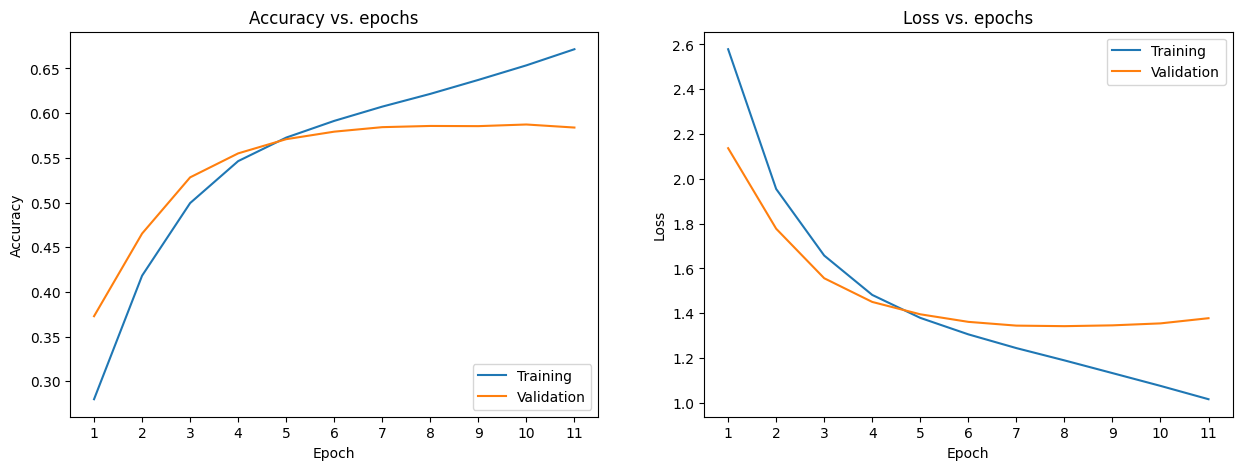

In [19]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history.history['preds_sparse_categorical_accuracy'])
plt.plot(history.history['val_preds_sparse_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history.history['preds_sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history.history['preds_sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history.history['preds_sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history.history['preds_sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

#### Write a text generation algorithm

An algorithm to generate text is as follows:

1. Specify a seed string (e.g. `'ROMEO:'`) to get the network started, and a define number of characters for the model to generate, `num_generation_steps`.
2. Tokenize the seed string to obtain a list containing one list of the integer tokens.
3. Reset the initial state of the recurrent network layer to zeros. 
4. Convert the token list into a Tensor (or numpy array) and pass it to your model as a batch of size one.
5. Get the model prediction (logits) for the last time step and extract the state of the recurrent layer.
6. Use the logits to construct a categorical distribution and sample a token from it.
7. Repeat the following for `num_generation_steps - 1` steps:

    1. Use the saved state of the recurrent layer and the last sampled token to get new logit predictions
    2. Use the logits to construct a new categorical distribution and sample a token from it.
    3. Save the updated state of the recurrent layer.    

8. Take the final list of tokens and convert to text using the TextVectorization layer vocabulary.

Note that we have built our RNN model to return the internal state of the recurrent layer, as well as the logits output from the `Dense` layer. For the GRU layer, the internal state is a single Tensor of shape `(batch_size, gru_units)`.

In [20]:
# Inspect the model's current recurrent state

for inputs, outputs in train_ds.take(1):
    print(rnn_model(inputs)[1])

tf.Tensor(
[[-0.8246053   0.7611019   0.7819262  ...  0.22772521  0.23302595
  -0.9631199 ]
 [ 0.47524837  0.34799504  0.8668984  ... -0.8906628   0.24193591
  -0.70467514]
 [-0.1751731  -0.8839044  -0.7453357  ... -0.7555082   0.37746978
   0.5009885 ]
 ...
 [ 0.9702519  -0.3572976  -0.9603013  ...  0.6067402   0.22723934
   0.12018345]
 [-0.18061614 -0.9290111   0.23346053 ... -0.20448607  0.9354503
   0.16655555]
 [-0.485097    0.98338515 -0.65660304 ... -0.8397451   0.85884506
  -0.845458  ]], shape=(32, 1024), dtype=float32)


We will break the algorithm down into two steps. First, you should complete the following `sample_token` function that takes a sequence of tokens of any length and returns a token prediction for the last time step. The specification is as follows:

* The function takes the `model` instance, `token_sequence` Tensor, and optional `initial_state` Tensor for the GRU layer
* The `token_sequence` will be an integer Tensor with shape `(batch_size, seq_length)`
  * The `seq_length` will be greater or equal to one
* If the function argument `initial_state` is `None`, then the function should reset the state of the recurrent layer to zeros
* Otherwise, if the function argument `initial_state` is a 2D Tensor or numpy array, it should be used as the initial state of the GRU layer
* Get the model's prediction (logits) for the last time step only
* Use the logits to form a categorical distribution and sample from it (*hint: you might find the* `tf.random.categorical` *function useful for this; see the documentation [here](https://www.tensorflow.org/api_docs/python/tf/random/categorical)*)
* The function should then return the sample as a 2D integer Tensor of shape `(batch_size, 1)` as well as an updated GRU layer state of shape `(batch_size, gru_units)` in a tuple `(samples, updated_state)`

In [21]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def sample_token(model, token_sequence, initial_state=None):
    """
    This function takes a model object, a token sequence and an optional initial
    state for the recurrent layer. The function should return the logits prediction
    for the final time step as a 2D numpy array.
    """
    h = token_sequence
    updated_state = None
    for i, layer in enumerate(model.layers):
        if i == 2:  
            h, updated_state = layer(h, initial_state=initial_state)
        else:
            h = layer(h)
    final_step = h[:, -1, :]  # (batch_size, num_tokens)
    samples = tf.random.categorical(final_step, 1)  # (batch_size, 1)
    return samples, updated_state

In [22]:
# Test your function by passing in a dummy token sequence

sample_token(rnn_model, tf.constant([[30, 2, 24], [16, 12, 33]]))

(<tf.Tensor: shape=(2, 1), dtype=int64, numpy=
 array([[5],
        [3]])>,
 <tf.Tensor: shape=(2, 1024), dtype=float32, numpy=
 array([[-0.17945798, -0.78629977, -0.66064465, ..., -0.6383311 ,
         -0.42598155, -0.6163845 ],
        [-0.46014094,  0.5311874 , -0.6195366 , ..., -0.9933233 ,
          0.5079227 , -0.81687117]], dtype=float32)>)

Finally, you should complete the following function to generate text from the model, given a seed string.

* This function takes the `model` instance, `seed_string`, `text_vectorization`, `num_generation_steps` and `sample_token` as arguments
* The function should first convert the `seed_string` to integer tokens using the `text_vectorization` object, and store them in a 2D integer Tensor with batch size equal to one
* The function should then run an internal loop for `num_generation_steps`:
  * In the first iteration through the loop, the integer token sequence should be passed to the `sample_token` function (passed in as an argument), to get the next sample token and updated GRU state
  * The `initial_state` can be set to `None` in the first iteration, in which case it is initialised to zeros
  * For the remaining iterations, the `sample_token` function should be called using the sampled token (with batch size and sequence length of one) and updated internal GRU state
* The `text_vectorization` object should then be used to convert the final sequence of integer tokens back to characters, and then concatenated to a single string
  * The final string will have length given by `num_generation_steps` plus the length of the initial seed string
* Your function should then return this final string

In [23]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def generate_text(model, seed_string, text_vectorization, num_generation_steps, sample_token=sample_token):
    """
    This function takes a model object, a seed string, a TextVectorization object and a 
    number of steps to generate characters as arguments. It should generate text 
    according to the above directions and return the extended string.
    """
    token_sequence = text_vectorization(seed_string)[tf.newaxis, ...]  # (1, seq_length)
    input_sequence = token_sequence
    initial_state = None
    for _ in range(num_generation_steps):
        sample, updated_state = sample_token(model, input_sequence, initial_state=initial_state)
        token_sequence = tf.concat((token_sequence, sample), axis=1)
        input_sequence = sample
        initial_state = updated_state
    
    inx_to_chars = {i: c for i, c in enumerate(text_vectorization.get_vocabulary())}
    final_token_sequence = tf.squeeze(token_sequence).numpy()
    final_char_sequence = [inx_to_chars[token] for token in final_token_sequence]
    return ''.join(final_char_sequence)

#### Generate text from the model

You are now ready to generate text from the model!

In [24]:
# Create a seed string and number of generation steps

init_string = 'ROMEO:'
num_generation_steps = 200

In [25]:
# Use your model and function above to generate text

print(generate_text(rnn_model, init_string, text_vectorization, num_generation_steps))

romeo:
i do remember when i had donnerd's char;
a hundred time my duty to't me in the queen
jucked on't it3 beg, but when you have for means beard,
good merrimag; as i love out,
with life hath rinds and t


Congratulations on completing this week's assignment! You have now built and trained a character-level RNN language model on text data, and used it to generate new text examples.